In [1]:
from lrgsglib.core import *

In [6]:
G = nx.dorogovtsev_goltsev_mendes_graph(4)

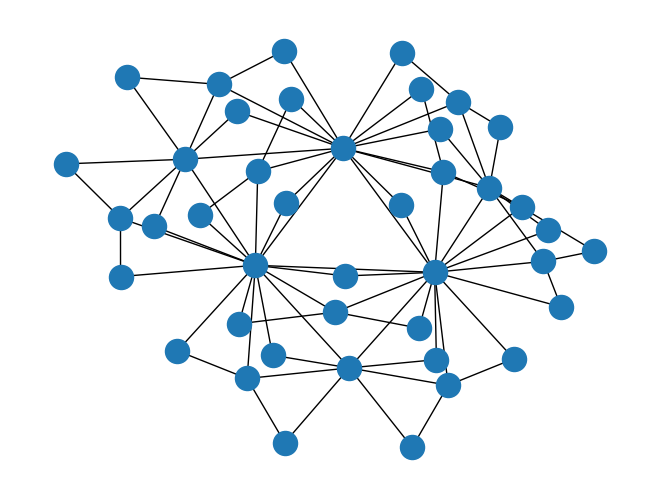

In [8]:
nx.draw(G)

In [19]:
eigv, P = np.linalg.eigh(nx.laplacian_matrix(G).toarray())
eigV = P.T

In [105]:
def complete_basis(vectors, tol=1e-8):
    """
    Extend k (≤ N-1) N-dimensional, zero-sum vectors to a basis of the zero-sum subspace (dim N-1),
    keeping the original vectors unchanged.

    Parameters
    ----------
    vectors : ndarray, shape (k, N)
        Input vectors; each must sum to zero and be linearly independent.
    tol : float
        Threshold below which a vector is treated as zero.

    Returns
    -------
    B : ndarray, shape (N-1, N)
        Basis of the hyperplane {x: sum(x)=0}, with first k rows = input vectors.
    """
    k, N = vectors.shape
    assert k <= N-1, "Need k ≤ N-1 to extend to zero-sum subspace"
    # preserve inputs, check zero-sum
    basis = [vectors[i].copy() for i in range(k)]
    ones = np.ones(N)

    # generate candidates e_i - (1/N)*1, which sum to zero
    for i in range(N):
        v = np.zeros(N)
        v[i] = 1.0
        v -= ones / N
        # orthogonalize against existing basis
        for b in basis:
            v -= b * (v @ b) / (b @ b)
        if np.linalg.norm(v) > tol:
            basis.append(v)

    return np.vstack(basis)

In [ ]:

def extend_eigenvalues(first_eigs, N, exponent, total_sum):
    """
    first_eigs: 1D array of the first k sorted eigenvalues
    N: total number of eigenvalues (> k)
    exponent: power‐law exponent α > 1
    total_sum: integer sum of all N eigenvalues
    """
    first = np.sort(first_eigs)
    k = first.size
    assert N > k, "N must exceed number of fixed eigenvalues"
    S0 = first.sum()
    assert total_sum > S0, "total_sum must exceed sum of first_eigs"
    S_rest = total_sum - S0

    xmin = first[-1]
    m = N - k
    u = np.random.rand(m)
    # inverse‐CDF sampling for p(x) ∝ x^(–exponent), x ≥ xmin
    samples = xmin * (1 - u)**(-1/(exponent - 1))

    # normalize to sum S_rest, then correct floating-point drift
    samples *= S_rest / samples.sum()
    samples[-1] += S_rest - samples.sum()

    return np.concatenate([first, np.sort(samples)])

In [142]:
vectors = eigV[:4]

In [143]:
full_basis = complete_basis(vectors)

In [145]:
part_eigv = eigv[:4]
part_eigv[0] = 0.

In [146]:
new_eigv = extend_eigenvalues(part_eigv, G.number_of_nodes(), 3.17/2-1, G.number_of_edges()*2)

In [147]:
ddmat = np.diag(new_eigv)

In [148]:
orig_lap = np.matmul(np.matmul(full_basis, ddmat), full_basis.T)

In [167]:
sum(full_basis[0])

6.48074069840786

In [163]:
part_eigv

array([0.        , 0.60594317, 0.60594317, 1.04937908])

In [171]:
_, eigV = np.linalg.eig(orig_lap)

In [174]:
eigV.T[0]

array([-2.65201421e-01,  1.58440401e-02,  5.69599157e-01,  3.08097810e-01,
       -3.25895037e-02,  5.76261689e-02,  5.59962679e-02,  8.26563868e-03,
        2.12364044e-03,  1.98841977e-01, -4.90522916e-02, -5.55888151e-02,
       -3.48938460e-02, -4.27166432e-02,  2.85348431e-02,  4.92090244e-02,
        2.40142653e-01,  3.81246874e-02,  2.61928072e-01, -2.72583766e-03,
       -5.76001775e-03, -3.85066267e-02, -4.68826933e-02, -1.35752895e-01,
       -1.62484883e-01, -1.09941386e-01, -1.30409474e-01,  4.56001599e-02,
        9.29554971e-03,  2.47520800e-01, -9.67064141e-02, -3.24646704e-02,
        5.65550974e-02,  2.84764768e-01, -1.28942569e-02,  2.76635707e-01,
       -7.18904633e-02, -3.44039909e-02, -6.11929327e-02, -2.54184404e-02,
       -2.78809243e-04, -1.44350337e-02])

In [164]:
sorted(np.linalg.eigvals(orig_lap)), new_eigv

([-9.096039842134076e-17,
  0.0023933478399385103,
  0.02309349464337368,
  0.13194262057971887,
  0.3189009269137067,
  0.3615156708260914,
  0.5835896455959332,
  0.5845119186545045,
  0.7498352765120659,
  0.7629704800391242,
  0.9663354409544891,
  0.9898325598864034,
  1.345852635295127,
  3.4014488961234055,
  3.4119711080408948,
  3.999145503593715,
  7.535040630032307,
  8.141446824017487,
  10.661740853366659,
  13.770001156640493,
  13.831627343976672,
  13.93924523267992,
  16.641740013408935,
  17.407655282729316,
  18.059490406921643,
  18.75615511558868,
  20.821656447181375,
  21.283869122792627,
  21.554237305905048,
  23.547917356444184,
  26.551143873453643,
  26.97193074366662,
  29.326793653364394,
  29.46663464067195,
  31.102962734146683,
  39.16209800783423,
  44.49568196527899,
  49.10681822413212,
  49.90167695146506,
  70.71622091347201,
  76.55295938490308,
  85.55268454553467],
 array([0.00000000e+00, 6.05943167e-01, 6.05943167e-01, 1.04937908e+00,
        2

In [161]:
adj = -orig_lap+np.diag(np.diag(orig_lap))

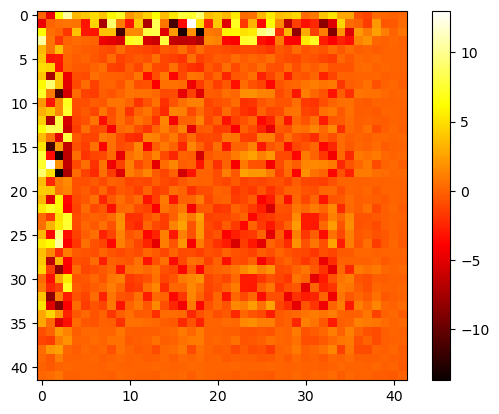

In [162]:
plt.imshow(adj, cmap='hot', interpolation='nearest')
plt.colorbar()

In [158]:
G = nx.from_numpy_array(adj)

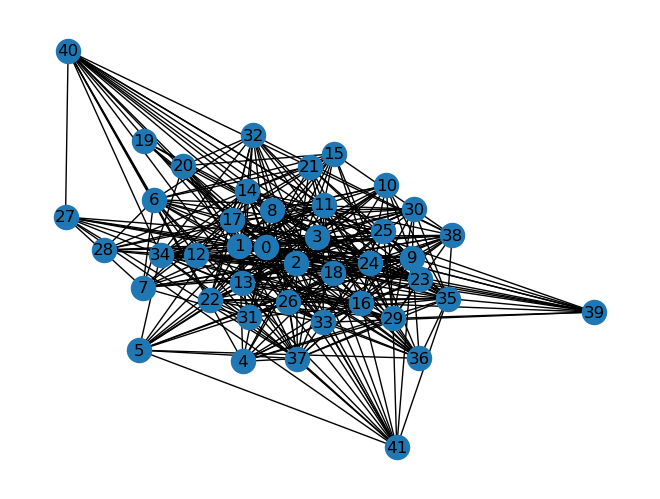

In [159]:
nx.draw(G, with_labels=True)    

In [134]:
adj

array([[0.        , 0.00120081, 0.00120081, ..., 0.00206916, 0.03062486,
        0.03062486],
       [0.00120081, 0.        , 0.00120332, ..., 0.0306225 , 0.        ,
        0.00207237],
       [0.00120081, 0.00120332, 0.        , ..., 0.        , 0.00251727,
        0.        ],
       ...,
       [0.00206916, 0.0306225 , 0.        , ..., 0.        , 0.        ,
        0.65420778],
       [0.03062486, 0.        , 0.00251727, ..., 0.        , 0.        ,
        0.        ],
       [0.03062486, 0.00207237, 0.        , ..., 0.65420778, 0.        ,
        0.        ]])

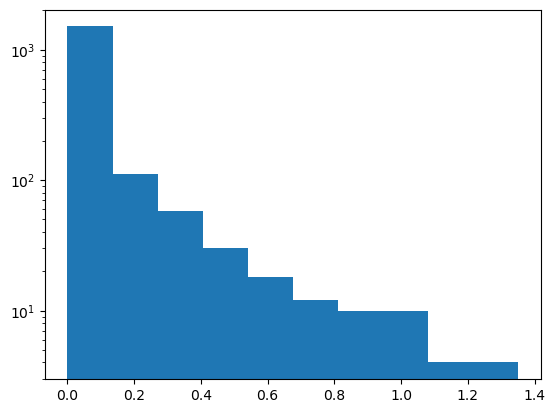

In [136]:
plt.hist(adj.flatten())
plt.yscale('log')

In [138]:
sorted(np.linalg.eigvals(orig_lap))

[-2.451660364203962e-15,
 1.4907141144370567e-11,
 0.00012077273528515945,
 0.016363005124076308,
 0.04595074093617973,
 0.07372487891241909,
 0.11404835972943159,
 0.19378572610955982,
 0.24051165780006736,
 0.25803053503511597,
 0.4251888798783906,
 0.45119403536456915,
 0.5936797383675699,
 0.6049395072282903,
 0.6059431673832474,
 0.6059431673832515,
 0.7179086107012718,
 0.8159061943745367,
 0.9638117412941081,
 1.0493790770036877,
 1.7262823523817072,
 2.1606366147039986,
 2.2501052106223427,
 2.2560702717263297,
 2.5021832036590843,
 2.8059910370718537,
 2.9233235279552323,
 3.0069094824294487,
 3.2239125321316675,
 4.204746969619041,
 4.321772545349099,
 4.433978645843488,
 4.895715642060421,
 5.039315840216073,
 5.217997143704768,
 5.472379283839987,
 5.565700801643566,
 5.882462138194589,
 5.95341378895672,
 6.44536446317695,
 7.0727234768399185,
 7.250851923465401]